# Exercise 9 - CIFAR10 Challenge

## Group ID: 
## Exercise day: 

## Task description:
In this exercise, you have all the freedom to come up with the best model, data augmentation, hyperparameters, loss function, etc. - essentially everything you have learned so far in the course - to achieve the highest possible accuracy on the CIFAR10 dataset.
You are allowed to use PyTorch functions for mechanisms which were covered in the previous exercises or lectures. But you are not allowed to use pre-trained models or any external dataset for training.
Also you have to provide a brief explanation of your model and all the decisions (hyperparameters, augmentation, etc.) you made to achieve the claimed accuracy.
To make the task more challenging, you have to train on an imbalanced traindataset.

Hint: For the final training process, you can use Google Colab which provides (time-restricted) free GPU resources.

## Submission:
- You have to submit a single .zip file containing this notebook and the weights of your model (model.pth).
- The total size of the .zip file must be less than 256MB. (absolute maximum, less is always better)
- The model file should be named model.pth.
- The test code at the end of your submitted notebook must run by only loading the provided model.pth file. We will not be able to run any training code.
- Upload the .zip via Ilias by clicking the **left** button called **"Datei hochladen"**(if you use the German version of Ilias). Please not use the right one, because Ilias will unzip your file in that case and can't handle .pth files.<br>
![](./upload.png)

## Evaluation:
The evaluation of the exercise is based on the achieved accuracy on the test dataset.
The baseline is 65% accuracy on the test dataset.

Note: The three best submissions will be awarded in the lecture with a small prize.

## Brief explanation of the model and the techniques used:
### Model Description 
We replicated the ResNext29 model for CIFAR-10:
https://arxiv.org/abs/1611.05431v2
- In short, the architecture utilizes more channels, but the channels are divided
into groups which don't share parameters between them. The number of groups
are called cardinarity and considered another hyperparameter important for 
fine-tuning.

According to this article, it performs better on CIFAR-10 comparing
to other CNN methods:
https://ieeexplore.ieee.org/abstract/document/10604269?casa_token=wK3e1i1MnKcAAAAA:9Uji_Pn9RWXctmx7_GeF8DnukBbJKLuNjPGppS4qY8b8s2IHzINBAR2WUg1JDKLVtZDLO5fXsA

### Other Decisions you made
- Batch Size:
- Number of Epochs:
- ...


## Code:


### Imports and data loading

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

Files already downloaded and verified
Files already downloaded and verified


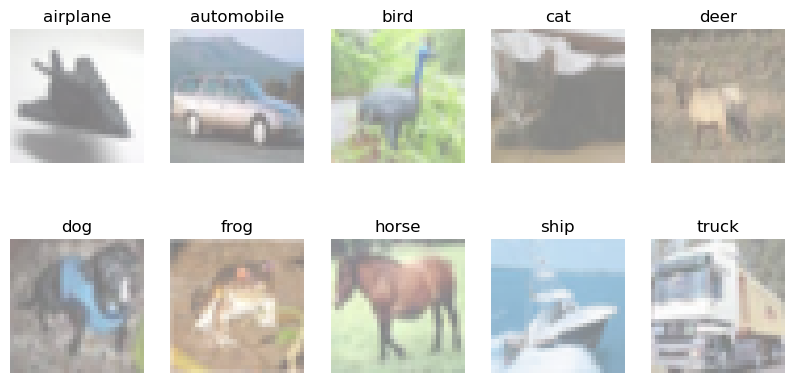

In [7]:
transform_train = transforms.Compose([transforms.ToTensor()])
transform_test = transforms.Compose([transforms.ToTensor()])

batch_size = 32

# Download and load the data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Create imbalanced traindataset
num_samples_per_class = {k:(k+1)*500 for k in range(10)}
class_to_indices = {cls: np.where(np.array(trainset.targets) == cls)[0] for cls in range(10)}
imbalanced_indices = []
for cls, count in num_samples_per_class.items():
    indices = class_to_indices[cls][:count]  # Select the first `count` samples
    imbalanced_indices.extend(indices)
imbalanced_trainset = Subset(trainset, imbalanced_indices)

trainloader = torch.utils.data.DataLoader(imbalanced_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]

# get one image from each class
images = []
for i in range(10):
    for image, label in trainset:
        if label == i:
            images.append(image)
            break

# plot the images
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    ax = axs[i//5, i%5]
    ax.imshow(images[i].permute(1, 2, 0).numpy() / 2 + 0.5)
    ax.set_title(classes[i])
    ax.axis('off')
plt.show()


### Model

Residual Blocks:

(i)if producing spatial maps of the same size, the blocks share
the same hyper-parameters (width and filter sizes), and 

(ii)
each time when the spatial map is downsampled by a factor of 2, the width of the blocks is multiplied by a factor
of 2.

ResNext performs well on CIFAR
https://arxiv.org/pdf/1611.05431v2

In [32]:
import torch.nn.functional as F
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, hiddenchannel, outchannel, stride=1, group = 1):
        super(ResidualBlock, self).__init__()
        # left: (in_size - 3 + 2)/s + 1 = (in_size -1)/s + 1 = out_size
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, hiddenchannel, kernel_size=1, stride=1, padding=0, bias=False, groups=group),
            nn.BatchNorm2d(hiddenchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(hiddenchannel, hiddenchannel, kernel_size=3, stride=stride, padding=1, bias=False, groups=group),
            nn.BatchNorm2d(hiddenchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(hiddenchannel, outchannel, kernel_size=1, stride=1, padding=0, bias=False, groups=group),
            nn.BatchNorm2d(outchannel),
        )
        # shortcut: (in_size - 1)/s + 1 = out_size
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                # zero padding to make the dimensions match
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out = out + self.shortcut(x)
        out = F.relu(out)

        return out

class ResNeXt29(nn.Module):
    def __init__(self, c_in=1, num_classes=10, cardinality=8):
        super(ResNeXt29, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(c_in, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            ResidualBlock(64, 128, 256, stride=3, group=cardinality),
            ResidualBlock(256, 128, 256, stride=3, group=cardinality),
            ResidualBlock(256, 128, 256, stride=3, group=cardinality),
        )
        self.conv3 = nn.Sequential(
            ResidualBlock(256, 256, 512, stride=3, group=cardinality),
            ResidualBlock(512, 256, 512, stride=3, group=cardinality),
            ResidualBlock(512, 256, 512, stride=3, group=cardinality),
        )
        self.conv4 = nn.Sequential(
            ResidualBlock(512, 512, 1024, stride=3, group=cardinality),
            ResidualBlock(1024, 512, 1024, stride=3, group=cardinality),
            ResidualBlock(1024, 512, 1024, stride=3, group=cardinality),
        )
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = F.avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

### Optimizer, Validation and Training

In [26]:
class Optimizer:
    def __init__(self, params, lr=0.01):
        self.params = list(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for param in self.params:
                param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            param.grad = None

In [27]:
def validate(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [28]:
def train(model, trainloader, testloader, criterion, optimizer, num_epochs=10, device='cpu'):
    model.to(device)
    acc_before = validate(model, testloader, device)
    print(f"Accuracy before training: {acc_before}")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data in tqdm(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, loss: {running_loss/len(trainloader)}")
        train_accuracy = validate(model, trainloader, device)
        print(f"Accuracy on train set: {train_accuracy}")
        accuracy = validate(model, testloader, device)
        print(f"Accuracy on test set: {accuracy}")

In [42]:
model = ResNeXt29(c_in = 3, num_classes = 10, cardinality = 32)
criterion = nn.CrossEntropyLoss()
optimizer = Optimizer(model.parameters(), lr=0.01)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device {device}")

Using device cuda


In [34]:
train(model, trainloader, testloader, criterion, optimizer, num_epochs=10, device=device)

Accuracy before training: 0.1


100%|██████████| 860/860 [00:31<00:00, 27.08it/s]


Epoch 1, loss: 1.9592804429142974
Accuracy on train set: 0.37563636363636366
Accuracy on test set: 0.2515


100%|██████████| 860/860 [00:31<00:00, 27.61it/s]


Epoch 2, loss: 1.7483241562233416
Accuracy on train set: 0.4182909090909091
Accuracy on test set: 0.2911


100%|██████████| 860/860 [00:31<00:00, 27.07it/s]


Epoch 3, loss: 1.6232083775276362
Accuracy on train set: 0.4762181818181818
Accuracy on test set: 0.331


100%|██████████| 860/860 [00:30<00:00, 27.80it/s]


Epoch 4, loss: 1.543609188115874
Accuracy on train set: 0.48403636363636365
Accuracy on test set: 0.3304


100%|██████████| 860/860 [00:30<00:00, 27.80it/s]


Epoch 5, loss: 1.4822490367778511
Accuracy on train set: 0.5160727272727272
Accuracy on test set: 0.3613


100%|██████████| 860/860 [00:30<00:00, 27.89it/s]


Epoch 6, loss: 1.4183558234641718
Accuracy on train set: 0.5503636363636364
Accuracy on test set: 0.3824


100%|██████████| 860/860 [00:31<00:00, 27.41it/s]


Epoch 7, loss: 1.3764095246791839
Accuracy on train set: 0.5653454545454546
Accuracy on test set: 0.3834


100%|██████████| 860/860 [00:31<00:00, 27.56it/s]


Epoch 8, loss: 1.323963829736377
Accuracy on train set: 0.5758181818181818
Accuracy on test set: 0.3956


100%|██████████| 860/860 [00:31<00:00, 27.41it/s]


Epoch 9, loss: 1.295422964595085
Accuracy on train set: 0.5978909090909091
Accuracy on test set: 0.4343


100%|██████████| 860/860 [00:30<00:00, 27.75it/s]


Epoch 10, loss: 1.2570531334987907
Accuracy on train set: 0.6056
Accuracy on test set: 0.4145


### Save the model

In [35]:
# save the model
torch.save(model.state_dict(), "model.pth")

### Load and test the model (this code will be used by us for testing)

```python

In [44]:
# load the model from .pth file
model = ResNeXt29(c_in = 3, num_classes = 10, cardinality = 32)

model.load_state_dict(torch.load("model.pth", weights_only=True))

# test the model
model.to(device)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')

Accuracy of the network on the 10000 test images: 41.45%
